<a href="https://colab.research.google.com/github/MohitDhungana/duplicate_question_detection/blob/master/Subin_dQd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install pydrive

!pip install google


In [77]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')

import itertools
import datetime


from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/Project')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Mounted at /content/drive


In [26]:
!ls '/content/drive/My Drive'


'Colab Notebooks'
 Compressed
 dogs-cats-images.zip
'energy environment and society  assignment.pdf'
 GoogleNews-vectors-negative300.bin.gz
 image-93b016bfc7ea033589b8766d020d99cb0108180bdaa53d05dbdaf5883674852e-V.jpg
 Keygen.exe
 KIC072BCT039.jpg
'New Doc 2019-03-03 12.05.252394441364277969478.pdf'
 Project
 the-new-encyclopedia-of-modern-bodybuilding-arnold.pdf
 train.csv


In [0]:
df = pd.read_csv('/content/drive/My Drive/train.csv')
stops = set(stopwords.words('english'))

def text_to_word_list(text):
#   gets a whole question inside text variable on which  preprocessing is done and then the question is splitted into word indices and returned
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [5]:
# Prepare embedding

vocabulary = dict() 
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions(i.e. 'question 1', 'question2') of the training sets provided 
# get the data from dataset(df) in  variable dataset
for dataset in [df]:
#   now iterate through the rows of the dataset using  index as iterator (i.e. goes through the row having particular index at a time) 
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions within the current  row
        for question in questions_cols:
            que2no = []  # que2no ->  numbers representation of the cureently being processed question
            
            count_ = 0

            for word in text_to_word_list(row[question]):

                # Check for unwanted words i.e mainly stopwords
                if word in stops and word not in word2vec.vocab:
                    continue
                    
#                 limit the length to 50, this decreased the time to train an epoch from more than 1 hour to 20 minutes.
                if count_ >= 50 :
                  continue
                count_ +=1
                
                
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    que2no.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    que2no.append(vocabulary[word])
#                     que2no.append(float(vocabulary[word]))

#                 que2no=list(map(int,que2no))

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, que2no)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [6]:
# max_sequence_length=50
max_seq_length = max(df.question1.map(lambda x: len(x)).max(),
                     df.question2.map(lambda x: len(x)).max()
                    )
# max_seq_length
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,"[26, 184, 3632, 115, 307, 8, 3, 24585, 522, 52...","[26, 184, 3632, 115, 307, 8, 12032, 522, 523, ...",0
404286,404286,18840,155606,"[97, 99, 2441, 307, 2, 598, 180, 1822]","[2, 47, 467, 77, 307, 2, 598, 180, 1822]",1
404287,404287,537928,537929,"[1, 2, 57, 11012]","[1, 2, 83, 11012]",0
404288,404288,537930,537931,"[1, 2, 3, 21205, 12587, 534, 2769, 33, 3114, 8...","[16, 42, 1086, 2877, 2854, 2622, 1220, 16, 173...",0
404289,404289,537932,537933,"[1, 2, 139, 401, 2543, 175, 7227]","[1, 2, 47, 139, 401, 2543, 175, 135, 7227]",0


In [0]:
embedding_dim = 300
# creating an embedding matrix whose length is one more than vocabulary and dimension is 300
embedding_matrix = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embedding_matrix[0] = 0  # So that the zeroth place remain empty 

# (Build the embedding matrix) Assigning the word2vec embedding for each words of our vocabulary  
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embedding_matrix[index] = word2vec.word_vec(word)

In [0]:
del word2vec


In [10]:
from sklearn.model_selection import train_test_split


X=df[questions_cols]
Y=df['is_duplicate']


x_train,x_validate,y_train,y_validate = train_test_split(X, Y, test_size = 0.3) # dataset split to 70% for training and 30% for validation

print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)
                 
# Split to dicts
x_train = {'left': x_train.question1, 'right': x_train.question2}
x_validate = {'left': x_validate.question1, 'right': x_validate.question2}

# Convert labels to their numpy representations
y_train=y_train.values
y_validate=y_validate.values



(283003, 2)
(121287, 2)
(283003,)
(121287,)


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# zero padding

for dataset, side in itertools.product([x_train,x_validate],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

In [12]:
# print(df['question1'][0])

# print(dataset)
print(x_train['left'].shape)
# print(x_train['left'])
print(x_validate['left'].shape)

(283003, 50)
(121287, 50)


In [15]:
print(x_train)

{'left': array([[   0,    0,    0, ..., 3878,  211, 4126],
       [   0,    0,    0, ...,  494,   92,  393],
       [   0,    0,    0, ..., 4348,  816, 7505],
       ...,
       [   0,    0,    0, ...,  139,  401,  898],
       [   0,    0,    0, ...,  383, 4461, 3635],
       [   0,    0,    0, ...,  167, 1145, 1245]], dtype=int32), 'right': array([[   0,    0,    0, ..., 1804,  536, 4126],
       [   0,    0,    0, ...,   30,   92,  393],
       [   0,    0,    0, ..., 9721,  816, 7505],
       ...,
       [   0,    0,    0, ...,  139,  401,  898],
       [   0,    0,    0, ..., 1450,  167, 1639],
       [   0,    0,    0, ...,  248,  161, 1245]], dtype=int32)}


In [52]:
# saving the training data
import pickle

pickle_out=open("x_train.pickle","wb")
pickle.dump(x_train,pickle_out)
pickle_out.close

pickle_out=open("x_validate.pickle","wb")
pickle.dump(x_validate,pickle_out)
pickle_out.close

pickle_out=open("y_train.pickle","wb")
pickle.dump(y_train,pickle_out)
pickle_out.close
pickle_out=open("y_validate.pickle","wb")
pickle.dump(y_validate,pickle_out)
pickle_out.close

<function BufferedWriter.close>

In [59]:
#uploading the pickle saved trained data in drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id='1nMGkHjtKSRoGEOVg5-r04Q0lvWGIWVpS'
# get the folder id where you want to save your file

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('x_train.pickle')
file.Upload() 


W0617 10:10:45.242820 140040332998528 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

In [60]:
#uploading the pickle saved trained data in drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id='1nMGkHjtKSRoGEOVg5-r04Q0lvWGIWVpS'
# get the folder id where you want to save your file

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('x_validate.pickle')
file.Upload() 

W0617 10:11:02.623712 140040332998528 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

In [61]:
#uploading the pickle saved trained data in drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id='1nMGkHjtKSRoGEOVg5-r04Q0lvWGIWVpS'
# get the folder id where you want to save your file

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('y_train.pickle')
file.Upload() 


W0617 10:11:19.359536 140040332998528 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

In [62]:
#uploading the pickle saved trained data in drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id='1nMGkHjtKSRoGEOVg5-r04Q0lvWGIWVpS'
# get the folder id where you want to save your file

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('y_validate.pickle')
file.Upload() 

W0617 10:11:36.395754 140040332998528 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

In [0]:
# loading the saved data from google drive
DATA_PATH = "/content/drive/My Drive/Project/Pickle"
infile = open(DATA_PATH+'/x_train.pickle','rb')
x_train = pickle.load(infile)
infile = open(DATA_PATH+'/x_validate.pickle','rb')
x_validate = pickle.load(infile)
infile = open(DATA_PATH+'/y_train.pickle','rb')
y_train = pickle.load(infile)
infile = open(DATA_PATH+'/y_validate.pickle','rb')
y_validate = pickle.load(infile)
##probably works dont really know need to check later

In [0]:
# check to see if shape of left and right input is same
assert x_train['left'].shape == x_train['right'].shape

# check to see if shape of input and output is same
assert len(x_train['left']) == len(y_train)

In [0]:
# shape of question1 column (x,y)==(total rows, total words in each question)
x_train['left'].shape

(283003, 50)

In [0]:
# manhattan distance calculation function
import tensorflow.keras.backend as K
def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right),axis=1, keepdims=True))

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda,CuDNNLSTM

n_hidden = 50
n_epochs=2
gradient_clipping_norm  = 1.25

# input layer
#recheck shape before training
left_input = Input(shape = (max_seq_length,), dtype='int32',name = 'left_input')
right_input = Input(shape = (max_seq_length,), dtype='int32', name = 'right_input')



# embedding layer
# recheck dims 
embedding_layer = Embedding(input_dim = len(embedding_matrix), output_dim = embedding_dim, input_length = max_seq_length, weights=[embedding_matrix], trainable=False, name = 'embedding_layer')

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)



#LSTM instantiation
# check parameter for LSTM.
shared_lstm = CuDNNLSTM(n_hidden, name = 'LSTM_layer')

# shared LSTM
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)




# TODO: check output shape of the output lambda layer
# output layer
output_layer = Lambda(function = lambda x : manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0],1))([left_output, right_output])



# define above model
model = tf.keras.Model(inputs=[left_input, right_input], outputs=output_layer)

# summary of model
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 50, 300)      25796400    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
LSTM_layer (CuDNNLSTM)          (None, 50)           70400       embedding_layer[0][0]        

In [76]:

# compile the model
from time import time
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import TensorBoard
# LOG_DIR="/root/logs"
# tensorboard = TensorBoard(log_dir=LOG_DIR.format(time()))

optimizer = Adadelta(clipnorm = gradient_clipping_norm)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])


# Start training
training_start_time = time()



# train (fit) the model
hist = model.fit([x_train['left'], x_train['right']], y_train, 
                 batch_size=64,
                 epochs=n_epochs, 
                 validation_data=([x_validate['left'], x_validate['right']], y_validate))
print(hist.history)


Using TensorFlow backend.


NameError: ignored

Training time finished.
2 epochs in 0:34:36.968637


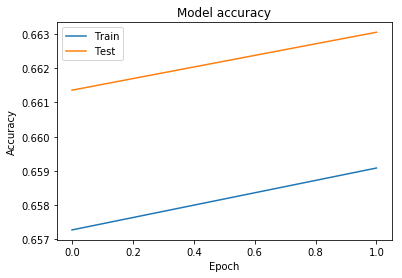

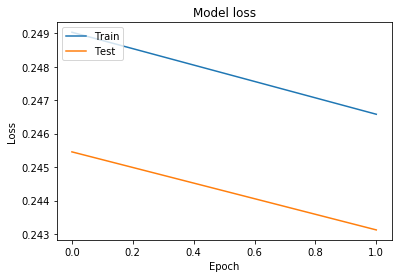

In [0]:

print("Training time finished.\n{} epochs in {}".format(2, datetime.timedelta(seconds=time()-training_start_time)))

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [82]:
#saving the model
model.save('/content/drive/My Drive/Project/DQD.h5')
!ls '/content/drive/My Drive'

'Colab Notebooks'
 Compressed
 dogs-cats-images.zip
'energy environment and society  assignment.pdf'
 GoogleNews-vectors-negative300.bin.gz
 image-93b016bfc7ea033589b8766d020d99cb0108180bdaa53d05dbdaf5883674852e-V.jpg
 Keygen.exe
 KIC072BCT039.jpg
'New Doc 2019-03-03 12.05.252394441364277969478.pdf'
 Project
 the-new-encyclopedia-of-modern-bodybuilding-arnold.pdf
 train.csv


In [83]:
#loading the model
file_obj = drive.CreateFile({'id': '1eRAXhgulFgBa3LDx8i8-Z5cUPdI0h3Zg'})     
file_obj.GetContentFile('DQD.h5'##doesnt work need to work on this shit

AttributeError: ignored

In [0]:
from tensoflow.keras.callbacks import tensorboard
import time()
NAME="DQD-LSTM-{}".format(int(time.time())) #timestamping
tensorboard= Tensorboard(log_dir='logs/{}'.format(NAME)) #call backs